In [3]:
import pandas as pd
import numpy as np
from itertools import product
from matplotlib import pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

## Data Preparation

In [4]:
df = pd.read_csv('GB electricity price.csv') 
print(df)

              Country ISO3 Code       Datetime (UTC)     Datetime (Local)  \
0      United Kingdom       GBR  2016-06-29 23:00:00  2016-06-30 00:00:00   
1      United Kingdom       GBR  2016-06-30 00:00:00  2016-06-30 01:00:00   
2      United Kingdom       GBR  2016-06-30 01:00:00  2016-06-30 02:00:00   
3      United Kingdom       GBR  2016-06-30 02:00:00  2016-06-30 03:00:00   
4      United Kingdom       GBR  2016-06-30 03:00:00  2016-06-30 04:00:00   
...               ...       ...                  ...                  ...   
82124  United Kingdom       GBR  2025-11-11 19:00:00  2025-11-11 19:00:00   
82125  United Kingdom       GBR  2025-11-11 20:00:00  2025-11-11 20:00:00   
82126  United Kingdom       GBR  2025-11-11 21:00:00  2025-11-11 21:00:00   
82127  United Kingdom       GBR  2025-11-11 22:00:00  2025-11-11 22:00:00   
82128  United Kingdom       GBR  2025-11-11 23:00:00  2025-11-11 23:00:00   

       Price (EUR/MWhe)  
0                 35.72  
1                 35.49

In [5]:
df = df[["Datetime (UTC)", "Price (EUR/MWhe)"]].copy()
df["Datetime (UTC)"] = pd.to_datetime(df["Datetime (UTC)"])
df = df.set_index("Datetime (UTC)").asfreq("H")
print(df)

                     Price (EUR/MWhe)
Datetime (UTC)                       
2016-06-29 23:00:00             35.72
2016-06-30 00:00:00             35.49
2016-06-30 01:00:00             35.07
2016-06-30 02:00:00             31.50
2016-06-30 03:00:00             30.27
...                               ...
2025-11-11 19:00:00             89.04
2025-11-11 20:00:00             85.78
2025-11-11 21:00:00             74.81
2025-11-11 22:00:00             58.12
2025-11-11 23:00:00             61.87

[82129 rows x 1 columns]


/var/folders/32/nhrql6ss1cq_ktc05s4h9rvm0000gp/T/ipykernel_7933/3844825146.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index("Datetime (UTC)").asfreq("H")


In [6]:
# sample size
price = df["Price (EUR/MWhe)"]

train = price.loc["2021-01-01":"2023-12-31"]
test  = price.loc["2024-01-01":"2024-12-31"]
print("Train starting from：", train.index[0], " ~ ", train.index[-1])
print("Test  starting from：", test.index[0],  " ~ ", test.index[-1])
print("Train length：", len(train))
print("Test  length：", len(test))

Train starting from： 2021-01-01 00:00:00  ~  2023-12-31 23:00:00
Test  starting from： 2024-01-01 00:00:00  ~  2024-12-31 23:00:00
Train length： 26280
Test  length： 8784


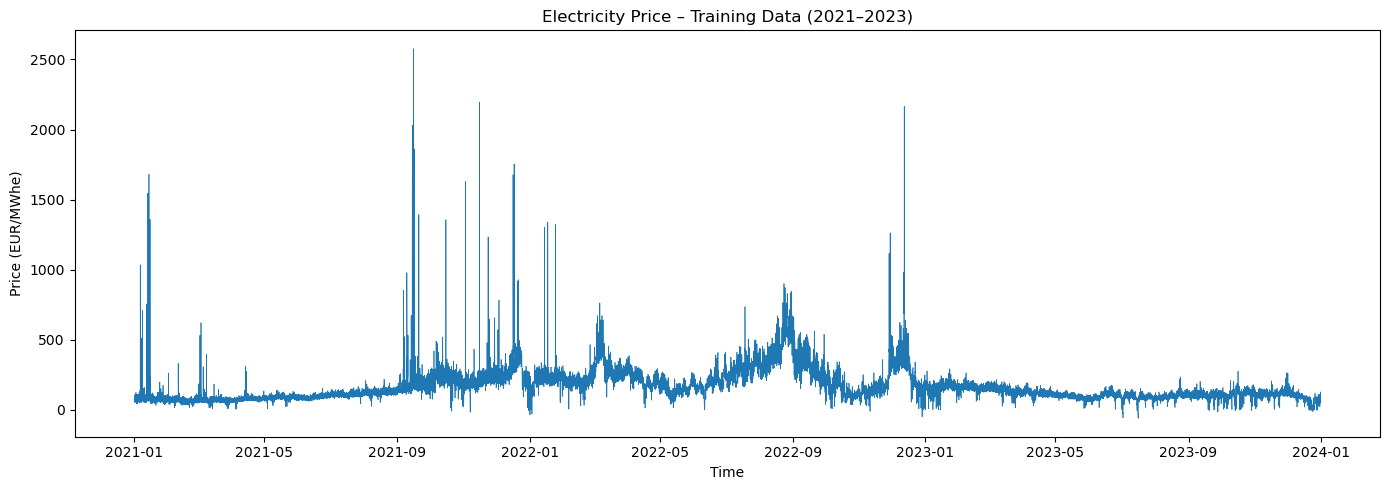

In [23]:
# hourly electricity data from 2021 to 2024
plt.figure(figsize=(14, 5))
plt.plot(train.index, train, linewidth=0.5)
plt.title("Electricity Price – Training Data (2021–2023)")
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWhe)")
plt.tight_layout()
plt.savefig("training_price_hourly.png", dpi=300, bbox_inches='tight')
plt.show()

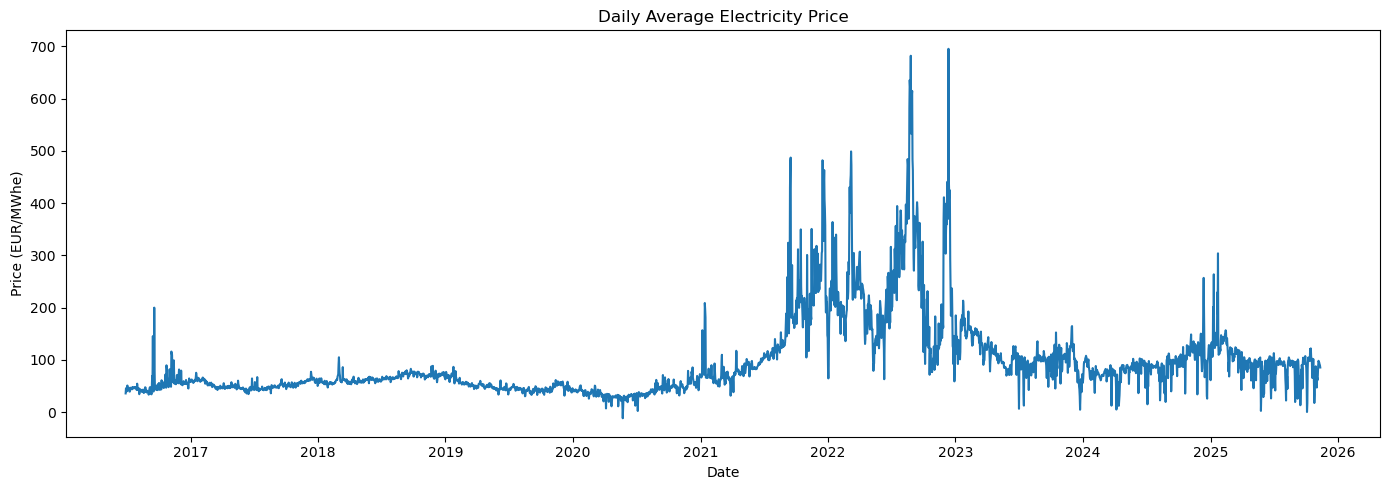

In [29]:
# daily electricity price from 2021-2024
daily_mean = price.resample("D").mean()

plt.figure(figsize=(14, 5))
plt.plot(daily_mean.index, daily_mean)
plt.title("Daily Average Electricity Price")
plt.xlabel("Date")
plt.ylabel("Price (EUR/MWhe)")
plt.tight_layout()
plt.show()

/var/folders/32/nhrql6ss1cq_ktc05s4h9rvm0000gp/T/ipykernel_84837/2009410452.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_monthly = train.resample("M").mean()


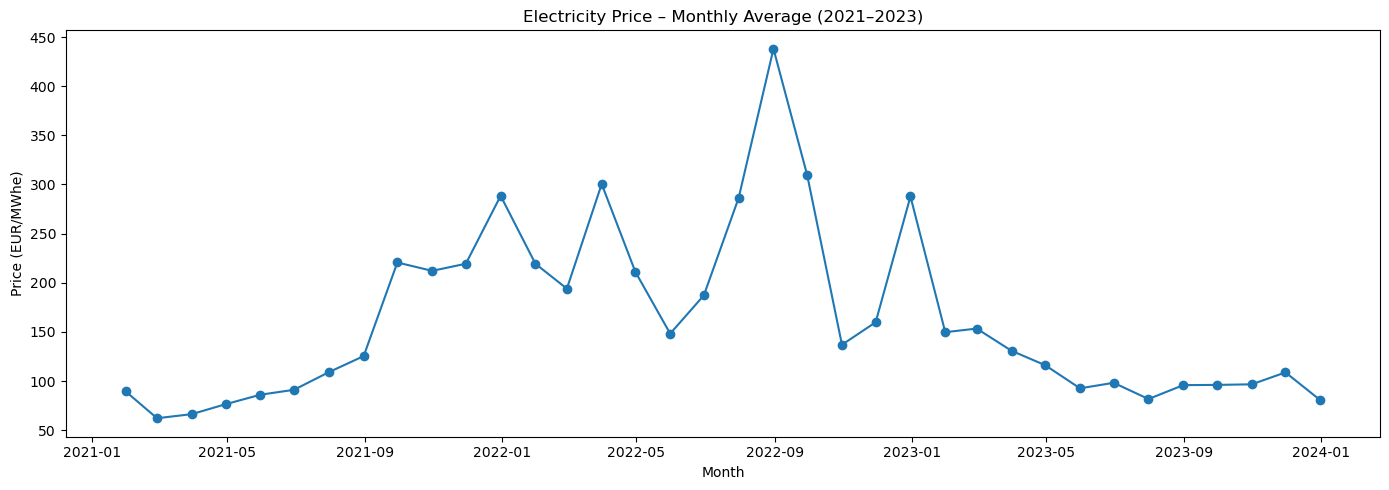

In [25]:
# monthly electricity data from 2021 to 2024
train_monthly = train.resample("M").mean()

plt.figure(figsize=(14, 5))
plt.plot(train_monthly.index, train_monthly, marker="o")
plt.title("Electricity Price – Monthly Average (2021–2023)")
plt.xlabel("Month")
plt.ylabel("Price (EUR/MWhe)")
plt.tight_layout()
plt.savefig("training_price_monthly_average.png", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# use adf test if stationary
y = df["Price (EUR/MWhe)"]
adf_res = adfuller(y, autolag='AIC')
adf_dict = {
    'ADF statistic': adf_res[0],
    'p-value': adf_res[1],
    'lags used': adf_res[2],
    'nobs': adf_res[3],
    'crit_1%': adf_res[4].get('1%'),
    'crit_5%': adf_res[4].get('5%'),
    'crit_10%': adf_res[4].get('10%'),
}

print("=== ADF Test Results for Electricity Price ===")
for k, v in adf_dict.items():
    print(f"{k}: {v}")

=== ADF Test Results for Electricity Price ===
ADF statistic: -7.582152001842674
p-value: 2.664355483757352e-11
lags used: 65
nobs: 82063
crit_1%: -3.4304296888312873
crit_5%: -2.861575221130113
crit_10%: -2.566788746989871


## ARIMA

In [33]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

best_bic = np.inf
best_aic = np.inf
best_order = None
best_model = None

p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()

                bic = result.bic
                aic = result.aic

                print(f"order=({p},{d},{q}), BIC={bic:.2f}, AIC={aic:.2f}")

                # 先比 BIC，再用 AIC 當 tie-breaker
                if (bic < best_bic) or (np.isclose(bic, best_bic) and aic < best_aic):
                    best_bic = bic
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = result

            except Exception as e:
                print(f"order=({p},{d},{q}) 失敗：{e}")
                continue

print("====================================")
print(f"用 BIC→AIC 選出的最佳 ARIMA = {best_order}, BIC = {best_bic:.2f}, AIC = {best_aic:.2f}")

# 用這個最佳模型在 2024 test 上算 RMSE（只是評估，不用來選模型）
forecast = best_model.forecast(steps=len(test))
best_rmse = np.sqrt(((forecast - test) ** 2).mean())
print(f"對 2024 test 的 RMSE = {best_rmse:.4f}")


order=(0,0,0), BIC=325947.96, AIC=325931.61


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(0,0,1), BIC=300081.82, AIC=300057.29
order=(0,0,2), BIC=288003.07, AIC=287970.37
order=(0,0,3), BIC=282174.47, AIC=282133.59
order=(0,1,0), BIC=276131.58, AIC=276123.41
order=(0,1,1), BIC=275317.66, AIC=275301.30
order=(0,1,2), BIC=274787.15, AIC=274762.62
order=(0,1,3), BIC=273248.94, AIC=273216.23
order=(1,0,0), BIC=275157.30, AIC=275132.77
order=(1,0,1), BIC=273911.67, AIC=273878.96
order=(1,0,2), BIC=273798.99, AIC=273758.11
order=(1,0,3), BIC=273231.73, AIC=273182.67
order=(1,1,0), BIC=275566.08, AIC=275549.73
order=(1,1,1), BIC=275125.56, AIC=275101.03


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(1,1,2), BIC=271474.40, AIC=271441.69
order=(1,1,3), BIC=271400.26, AIC=271359.37
order=(2,0,0), BIC=274180.37, AIC=274147.66
order=(2,0,1), BIC=273855.62, AIC=273814.73


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(2,0,2), BIC=271493.33, AIC=271444.27


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(2,0,3), BIC=271420.62, AIC=271363.38
order=(2,1,0), BIC=274649.43, AIC=274624.90
order=(2,1,1), BIC=271340.32, AIC=271307.62


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(2,1,2), BIC=271343.73, AIC=271302.84


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(2,1,3), BIC=271247.68, AIC=271198.62
order=(3,0,0), BIC=273662.58, AIC=273621.70


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(3,0,1), BIC=271356.26, AIC=271307.20


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(3,0,2), BIC=271361.05, AIC=271303.81


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(3,0,3), BIC=271416.68, AIC=271351.27
order=(3,1,0), BIC=274361.65, AIC=274328.95


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(3,1,1), BIC=271345.92, AIC=271305.04
order=(3,1,2), BIC=271323.82, AIC=271274.76


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(3,1,3), BIC=271265.65, AIC=271208.42
用 BIC→AIC 選出的最佳 ARIMA = (2, 1, 3), BIC = 271247.68, AIC = 271198.62
對 2024 test 的 RMSE = 37.1222


In [36]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd   # make sure this is imported

best_model = None

p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

results = []  # 用來存所有成功估計的模型結果

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()

                bic = result.bic
                aic = result.aic

                print(f"order=({p},{d},{q}), BIC={bic:.2f}, AIC={aic:.2f}")

                # 存進 list，等等變 DataFrame
                results.append({
                    "p": p,
                    "d": d,
                    "q": q,
                    "BIC": bic,
                    "AIC": aic
                })

            except Exception as e:
                print(f"order=({p},{d},{q}) 失敗：{e}")
                continue

# 變成 DataFrame，並依 BIC 再 AIC 排序
orders_df = pd.DataFrame(results).sort_values(["BIC", "AIC"]).reset_index(drop=True)

print("====================================")
print("所有模型（依 BIC→AIC 排序）前幾筆：")
print(orders_df)

# 取出最佳那一行
best_row = orders_df.loc[0]
best_order = (int(best_row["p"]), int(best_row["d"]), int(best_row["q"]))
best_bic = best_row["BIC"]
best_aic = best_row["AIC"]

print(f"\n用 BIC→AIC 選出的最佳 ARIMA = {best_order}, BIC = {best_bic:.2f}, AIC = {best_aic:.2f}")

# 用最佳模型重新 fit 一次
best_model = ARIMA(train, order=best_order).fit()

# 在 2024 test 上算 RMSE（只是評估）
forecast = best_model.forecast(steps=len(test))
best_rmse = np.sqrt(((forecast - test) ** 2).mean())
print(f"對 2024 test 的 RMSE = {best_rmse:.4f}")


order=(0,0,0), BIC=325947.96, AIC=325931.61


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(0,0,1), BIC=300081.82, AIC=300057.29
order=(0,0,2), BIC=288003.07, AIC=287970.37
order=(0,0,3), BIC=282174.47, AIC=282133.59
order=(0,1,0), BIC=276131.58, AIC=276123.41
order=(0,1,1), BIC=275317.66, AIC=275301.30
order=(0,1,2), BIC=274787.15, AIC=274762.62
order=(0,1,3), BIC=273248.94, AIC=273216.23
order=(1,0,0), BIC=275157.30, AIC=275132.77
order=(1,0,1), BIC=273911.67, AIC=273878.96
order=(1,0,2), BIC=273798.99, AIC=273758.11
order=(1,0,3), BIC=273231.73, AIC=273182.67
order=(1,1,0), BIC=275566.08, AIC=275549.73
order=(1,1,1), BIC=275125.56, AIC=275101.03


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(1,1,2), BIC=271474.40, AIC=271441.69
order=(1,1,3), BIC=271400.26, AIC=271359.37
order=(2,0,0), BIC=274180.37, AIC=274147.66
order=(2,0,1), BIC=273855.62, AIC=273814.73


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(2,0,2), BIC=271493.33, AIC=271444.27


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(2,0,3), BIC=271420.62, AIC=271363.38
order=(2,1,0), BIC=274649.43, AIC=274624.90
order=(2,1,1), BIC=271340.32, AIC=271307.62


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(2,1,2), BIC=271343.73, AIC=271302.84


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(2,1,3), BIC=271247.68, AIC=271198.62
order=(3,0,0), BIC=273662.58, AIC=273621.70


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(3,0,1), BIC=271356.26, AIC=271307.20


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(3,0,2), BIC=271361.05, AIC=271303.81


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(3,0,3), BIC=271416.68, AIC=271351.27
order=(3,1,0), BIC=274361.65, AIC=274328.95


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


order=(3,1,1), BIC=271345.92, AIC=271305.04
order=(3,1,2), BIC=271323.82, AIC=271274.76


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order=(3,1,3), BIC=271265.65, AIC=271208.42
所有模型（依 BIC→AIC 排序）前幾筆：
    p  d  q            BIC            AIC
0   2  1  3  271247.676147  271198.616995
1   3  1  3  271265.654187  271208.418509
2   3  1  2  271323.819126  271274.759973
3   2  1  1  271340.324931  271307.618829
4   2  1  2  271343.727117  271302.844490
5   3  1  1  271345.923759  271305.041132
6   3  0  1  271356.262468  271307.203087
7   3  0  2  271361.050206  271303.814262
8   1  1  3  271400.257037  271359.374409
9   3  0  3  271416.681083  271351.268575
10  2  0  3  271420.616486  271363.380542
11  1  1  2  271474.398760  271441.692658
12  2  0  2  271493.331934  271444.272553
13  1  0  3  273231.728339  273182.668959
14  0  1  3  273248.937545  273216.231443
15  3  0  0  273662.582609  273621.699792
16  1  0  2  273798.990139  273758.107322
17  2  0  1  273855.617476  273814.734658
18  1  0  1  273911.665107  273878.958853
19  2  0  0  274180.369599  274147.663345
20  3  1  0  274361.651188  274328.945086
21  2  1 

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


對 2024 test 的 RMSE = 37.1222


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


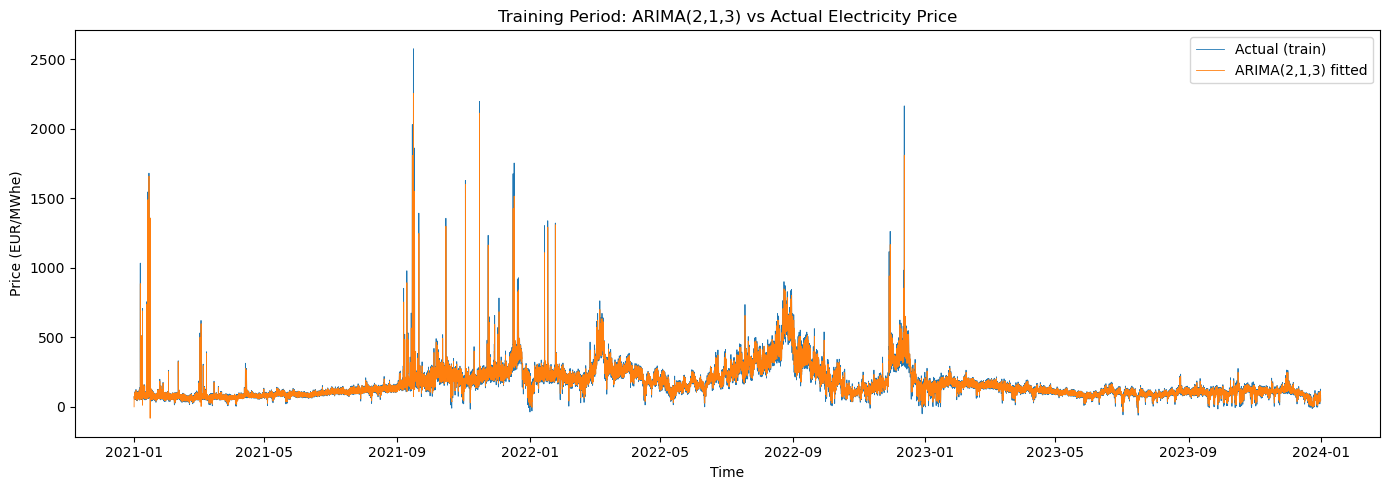

In [37]:
# plot the in-sample fitted value from best ARIMA model
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 1. Fit ARIMA(2,1,3) on the training data
model_213 = ARIMA(train, order=(2, 1, 3))
result_213 = model_213.fit()

# 2. Get in-sample predictions on the training period (one-step-ahead)
fitted_213 = result_213.predict(start=train.index[0], end=train.index[-1])

# 3. Plot actual vs fitted on the training period
plt.figure(figsize=(14, 5))
plt.plot(train.index, train, label="Actual (train)", linewidth=0.6)
plt.plot(fitted_213.index, fitted_213, label="ARIMA(2,1,3) fitted", linewidth=0.6)
plt.title("Training Period: ARIMA(2,1,3) vs Actual Electricity Price")
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWhe)")
plt.legend()
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2,1,3) RMSE on 2024 test: 37.122208994012304


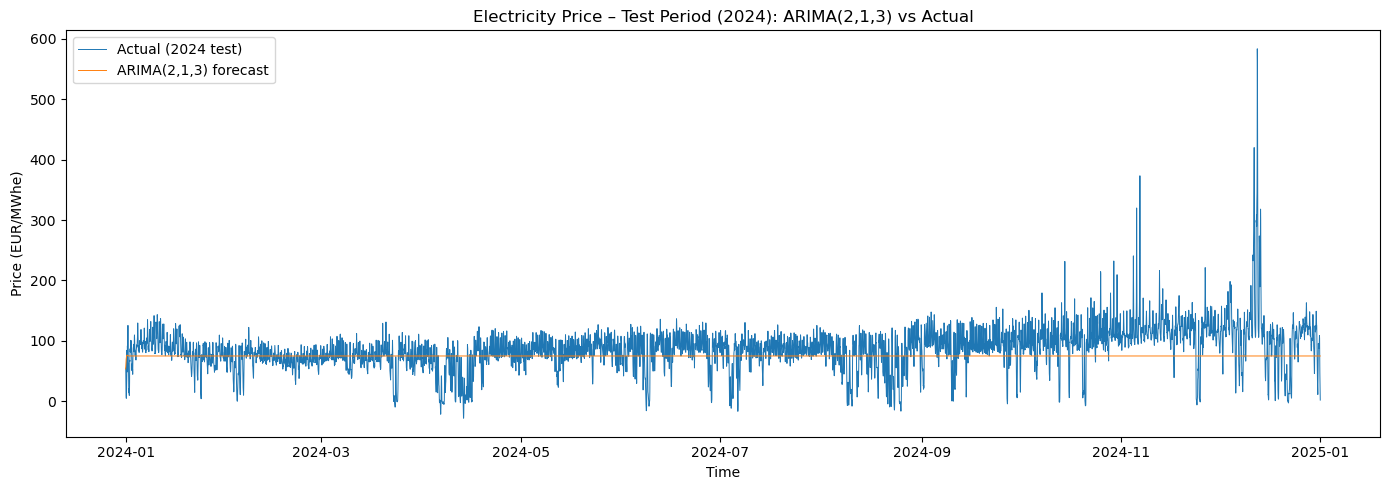

In [38]:
# plot the forecast of test data
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np

# 1. Fit ARIMA(2,1,3) on training data
model_213 = ARIMA(train, order=(2, 1, 3))
result_213 = model_213.fit()

# 2. Forecast over the test period (same length as test)
forecast_test_213 = result_213.forecast(steps=len(test))

# 3. Optional: compute RMSE on test
rmse_213 = np.sqrt(((forecast_test_213 - test) ** 2).mean())
print("ARIMA(2,1,3) RMSE on 2024 test:", rmse_213)

# 4. Plot: ARIMA(2,1,3) forecast vs actual (test data)
plt.figure(figsize=(14, 5))
plt.plot(test.index, test, label="Actual (2024 test)", linewidth=0.7)
plt.plot(test.index, forecast_test_213, label="ARIMA(2,1,3) forecast", linewidth=0.7)
plt.title("Electricity Price – Test Period (2024): ARIMA(2,1,3) vs Actual")
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWhe)")
plt.legend()
plt.tight_layout()
plt.show()

## SARIMA

In [39]:
import numpy as np
import pandas as pd
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --------- parameter ranges (you can adjust) ----------
p_values = range(0, 3)   # 0,1,2
d_values = [0, 1]
q_values = range(0, 3)

P_values = range(0, 2)   # 0,1
D_values = [0, 1]
Q_values = range(0, 2)

s = 24  # seasonal period = 24 hours (daily)

results = []

# --------- grid search over SARIMA(p,d,q)(P,D,Q,24) ----------
for p, d, q in product(p_values, d_values, q_values):
    for P, D, Q in product(P_values, D_values, Q_values):
        # 避免全 0 的無聊模型
        if (p, d, q, P, D, Q) == (0, 0, 0, 0, 0, 0):
            continue
        try:
            model = SARIMAX(
                train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fit = model.fit(disp=False)

            bic = fit.bic
            aic = fit.aic

            if np.isfinite(bic) and np.isfinite(aic):
                print(f"(p,d,q)=({p},{d},{q}), (P,D,Q,24)=({P},{D},{Q},{s}), BIC={bic:.2f}, AIC={aic:.2f}")
                results.append({
                    "p": p, "d": d, "q": q,
                    "P": P, "D": D, "Q": Q,
                    "BIC": bic, "AIC": aic
                })
        except Exception as e:
            print(f"(p,d,q)=({p},{d},{q}), (P,D,Q,24)=({P},{D},{Q},{s}) 失敗: {e}")
            continue

# --------- make DataFrame and sort by BIC → AIC ----------
if not results:
    raise RuntimeError("No valid SARIMA models were estimated. Try smaller ranges or check data.")

sarima_df = (
    pd.DataFrame(results)
    .sort_values(["BIC", "AIC"])
    .reset_index(drop=True)
)

print("\nTop 10 SARIMA candidates (sorted by BIC then AIC):")
print(sarima_df.head(10))

# best model parameters
best_row = sarima_df.loc[0]
best_order = (int(best_row["p"]), int(best_row["d"]), int(best_row["q"]))
best_seasonal = (int(best_row["P"]), int(best_row["D"]), int(best_row["Q"]), s)

print(f"\nBest SARIMA by BIC→AIC:")
print(f"  order         = {best_order}")
print(f"  seasonal_order= {best_seasonal}")
print(f"  BIC           = {best_row['BIC']:.2f}")
print(f"  AIC           = {best_row['AIC']:.2f}")

# --------- refit best model and evaluate on test ----------
best_model = SARIMAX(
    train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

forecast_test = best_model.forecast(steps=len(test))
rmse = np.sqrt(((forecast_test - test) ** 2).mean())
print(f"\nRMSE on 2024 test (for best SARIMA) = {rmse:.4f}")


(p,d,q)=(0,0,0), (P,D,Q,24)=(0,0,1,24), BIC=328920.09, AIC=328903.74
(p,d,q)=(0,0,0), (P,D,Q,24)=(0,1,0,24), BIC=295716.04, AIC=295707.87
(p,d,q)=(0,0,0), (P,D,Q,24)=(0,1,1,24), BIC=292293.83, AIC=292277.48
(p,d,q)=(0,0,0), (P,D,Q,24)=(1,0,0,24), BIC=294988.10, AIC=294971.75
(p,d,q)=(0,0,0), (P,D,Q,24)=(1,0,1,24), BIC=292375.44, AIC=292350.91
(p,d,q)=(0,0,0), (P,D,Q,24)=(1,1,0,24), BIC=293966.73, AIC=293950.38
(p,d,q)=(0,0,0), (P,D,Q,24)=(1,1,1,24), BIC=290704.55, AIC=290680.02
(p,d,q)=(0,0,1), (P,D,Q,24)=(0,0,0,24), BIC=323309.93, AIC=323293.58
(p,d,q)=(0,0,1), (P,D,Q,24)=(0,0,1,24), BIC=303634.26, AIC=303609.74
(p,d,q)=(0,0,1), (P,D,Q,24)=(0,1,0,24), BIC=278847.03, AIC=278830.68
(p,d,q)=(0,0,1), (P,D,Q,24)=(0,1,1,24), BIC=274179.76, AIC=274155.24
(p,d,q)=(0,0,1), (P,D,Q,24)=(1,0,0,24), BIC=277794.01, AIC=277769.48
(p,d,q)=(0,0,1), (P,D,Q,24)=(1,0,1,24), BIC=274248.25, AIC=274215.55
(p,d,q)=(0,0,1), (P,D,Q,24)=(1,1,0,24), BIC=276512.98, AIC=276488.46
(p,d,q)=(0,0,1), (P,D,Q,24)=(1,1,1

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(p,d,q)=(0,0,2), (P,D,Q,24)=(1,0,1,24), BIC=275463.15, AIC=275422.27
(p,d,q)=(0,0,2), (P,D,Q,24)=(1,1,0,24), BIC=271760.82, AIC=271728.12
(p,d,q)=(0,0,2), (P,D,Q,24)=(1,1,1,24), BIC=267333.18, AIC=267292.31
(p,d,q)=(0,1,0), (P,D,Q,24)=(0,0,0,24), BIC=276122.07, AIC=276113.90
(p,d,q)=(0,1,0), (P,D,Q,24)=(0,0,1,24), BIC=270182.37, AIC=270166.02
(p,d,q)=(0,1,0), (P,D,Q,24)=(0,1,0,24), BIC=275617.18, AIC=275609.01
(p,d,q)=(0,1,0), (P,D,Q,24)=(0,1,1,24), BIC=268048.31, AIC=268031.96
(p,d,q)=(0,1,0), (P,D,Q,24)=(1,0,0,24), BIC=268175.63, AIC=268159.28
(p,d,q)=(0,1,0), (P,D,Q,24)=(1,0,1,24), BIC=267583.55, AIC=267559.03
(p,d,q)=(0,1,0), (P,D,Q,24)=(1,1,0,24), BIC=272474.96, AIC=272458.61
(p,d,q)=(0,1,0), (P,D,Q,24)=(1,1,1,24), BIC=265946.44, AIC=265921.92
(p,d,q)=(0,1,1), (P,D,Q,24)=(0,0,0,24), BIC=275298.64, AIC=275282.29
(p,d,q)=(0,1,1), (P,D,Q,24)=(0,0,1,24), BIC=269850.11, AIC=269825.58
(p,d,q)=(0,1,1), (P,D,Q,24)=(0,1,0,24), BIC=275611.04, AIC=275594.68
(p,d,q)=(0,1,1), (P,D,Q,24)=(0,1,1

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(p,d,q)=(1,0,0), (P,D,Q,24)=(0,1,0,24), BIC=272390.33, AIC=272373.98
(p,d,q)=(1,0,0), (P,D,Q,24)=(0,1,1,24), BIC=265609.80, AIC=265585.27
(p,d,q)=(1,0,0), (P,D,Q,24)=(1,0,0,24), BIC=267257.22, AIC=267232.70
(p,d,q)=(1,0,0), (P,D,Q,24)=(1,0,1,24), BIC=265535.05, AIC=265502.35
(p,d,q)=(1,0,0), (P,D,Q,24)=(1,1,0,24), BIC=269444.96, AIC=269420.44
(p,d,q)=(1,0,0), (P,D,Q,24)=(1,1,1,24), BIC=263614.53, AIC=263581.83
(p,d,q)=(1,0,1), (P,D,Q,24)=(0,0,0,24), BIC=274824.01, AIC=274799.48
(p,d,q)=(1,0,1), (P,D,Q,24)=(0,0,1,24), BIC=269193.27, AIC=269160.56
(p,d,q)=(1,0,1), (P,D,Q,24)=(0,1,0,24), BIC=271676.68, AIC=271652.15
(p,d,q)=(1,0,1), (P,D,Q,24)=(0,1,1,24), BIC=264837.90, AIC=264805.20
(p,d,q)=(1,0,1), (P,D,Q,24)=(1,0,0,24), BIC=266946.50, AIC=266913.80
(p,d,q)=(1,0,1), (P,D,Q,24)=(1,0,1,24), BIC=264807.19, AIC=264766.31
(p,d,q)=(1,0,1), (P,D,Q,24)=(1,1,0,24), BIC=268645.34, AIC=268612.65
(p,d,q)=(1,0,1), (P,D,Q,24)=(1,1,1,24), BIC=262988.18, AIC=262947.30
(p,d,q)=(1,0,2), (P,D,Q,24)=(0,0,0

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(p,d,q)=(2,0,1), (P,D,Q,24)=(0,0,1,24), BIC=269011.06, AIC=268970.18
(p,d,q)=(2,0,1), (P,D,Q,24)=(0,1,0,24), BIC=271615.44, AIC=271582.74
(p,d,q)=(2,0,1), (P,D,Q,24)=(0,1,1,24), BIC=264746.52, AIC=264705.65
(p,d,q)=(2,0,1), (P,D,Q,24)=(1,0,0,24), BIC=266701.02, AIC=266660.14
(p,d,q)=(2,0,1), (P,D,Q,24)=(1,0,1,24), BIC=265422.85, AIC=265373.80
(p,d,q)=(2,0,1), (P,D,Q,24)=(1,1,0,24), BIC=268571.87, AIC=268531.00
(p,d,q)=(2,0,1), (P,D,Q,24)=(1,1,1,24), BIC=262877.08, AIC=262828.03
(p,d,q)=(2,0,2), (P,D,Q,24)=(0,0,0,24), BIC=271658.85, AIC=271617.97
(p,d,q)=(2,0,2), (P,D,Q,24)=(0,0,1,24), BIC=269165.90, AIC=269116.84
(p,d,q)=(2,0,2), (P,D,Q,24)=(0,1,0,24), BIC=271424.14, AIC=271383.26
(p,d,q)=(2,0,2), (P,D,Q,24)=(0,1,1,24), BIC=263983.08, AIC=263934.03


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(p,d,q)=(2,0,2), (P,D,Q,24)=(1,0,0,24), BIC=265629.61, AIC=265580.56


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(p,d,q)=(2,0,2), (P,D,Q,24)=(1,0,1,24), BIC=265270.32, AIC=265213.09
(p,d,q)=(2,0,2), (P,D,Q,24)=(1,1,0,24), BIC=268334.17, AIC=268285.12


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(p,d,q)=(2,0,2), (P,D,Q,24)=(1,1,1,24), BIC=262088.64, AIC=262031.41
(p,d,q)=(2,1,0), (P,D,Q,24)=(0,0,0,24), BIC=274630.42, AIC=274605.89
(p,d,q)=(2,1,0), (P,D,Q,24)=(0,0,1,24), BIC=268963.89, AIC=268931.19
(p,d,q)=(2,1,0), (P,D,Q,24)=(0,1,0,24), BIC=274226.58, AIC=274202.05
(p,d,q)=(2,1,0), (P,D,Q,24)=(0,1,1,24), BIC=266729.75, AIC=266697.05
(p,d,q)=(2,1,0), (P,D,Q,24)=(1,0,0,24), BIC=266917.22, AIC=266884.51
(p,d,q)=(2,1,0), (P,D,Q,24)=(1,0,1,24), BIC=266262.90, AIC=266222.02
(p,d,q)=(2,1,0), (P,D,Q,24)=(1,1,0,24), BIC=271079.67, AIC=271046.97
(p,d,q)=(2,1,0), (P,D,Q,24)=(1,1,1,24), BIC=264646.31, AIC=264605.43
(p,d,q)=(2,1,1), (P,D,Q,24)=(0,0,0,24), BIC=271322.85, AIC=271290.14
(p,d,q)=(2,1,1), (P,D,Q,24)=(0,0,1,24), BIC=266047.15, AIC=266006.27
(p,d,q)=(2,1,1), (P,D,Q,24)=(0,1,0,24), BIC=271916.91, AIC=271884.21
(p,d,q)=(2,1,1), (P,D,Q,24)=(0,1,1,24), BIC=264223.67, AIC=264182.79
(p,d,q)=(2,1,1), (P,D,Q,24)=(1,0,0,24), BIC=264383.04, AIC=264342.16
(p,d,q)=(2,1,1), (P,D,Q,24)=(1,0,1

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(p,d,q)=(2,1,2), (P,D,Q,24)=(1,0,1,24), BIC=263752.85, AIC=263695.62


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(p,d,q)=(2,1,2), (P,D,Q,24)=(1,1,0,24), BIC=268580.87, AIC=268531.82
(p,d,q)=(2,1,2), (P,D,Q,24)=(1,1,1,24), BIC=262167.65, AIC=262110.43

Top 10 SARIMA candidates (sorted by BIC then AIC):
   p  d  q  P  D  Q            BIC            AIC
0  2  0  2  1  1  1  262088.636703  262031.414356
1  2  1  2  1  1  1  262167.653840  262110.431760
2  1  1  2  1  1  1  262169.460604  262120.413107
3  2  1  1  1  1  1  262304.373109  262255.325383
4  1  0  2  1  1  1  262738.311487  262689.263761
5  2  0  1  1  1  1  262877.076256  262828.028302
6  1  0  1  1  1  1  262988.176251  262947.302956
7  2  0  0  1  1  1  263149.546654  263108.673359
8  1  1  1  1  1  1  263152.608309  263111.735204
9  1  0  0  1  1  1  263614.529695  263581.830906

Best SARIMA by BIC→AIC:
  order         = (2, 0, 2)
  seasonal_order= (1, 1, 1, 24)
  BIC           = 262088.64
  AIC           = 262031.41


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



RMSE on 2024 test (for best SARIMA) = 35.6432


In [7]:
price = df["Price (EUR/MWhe)"]
train = price.loc["2021-01-01":"2023-12-31"]
test  = price.loc["2024-01-01":"2024-12-31"]

best_order = (2, 0, 2)
best_seasonal = (1, 1, 1, 24)

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


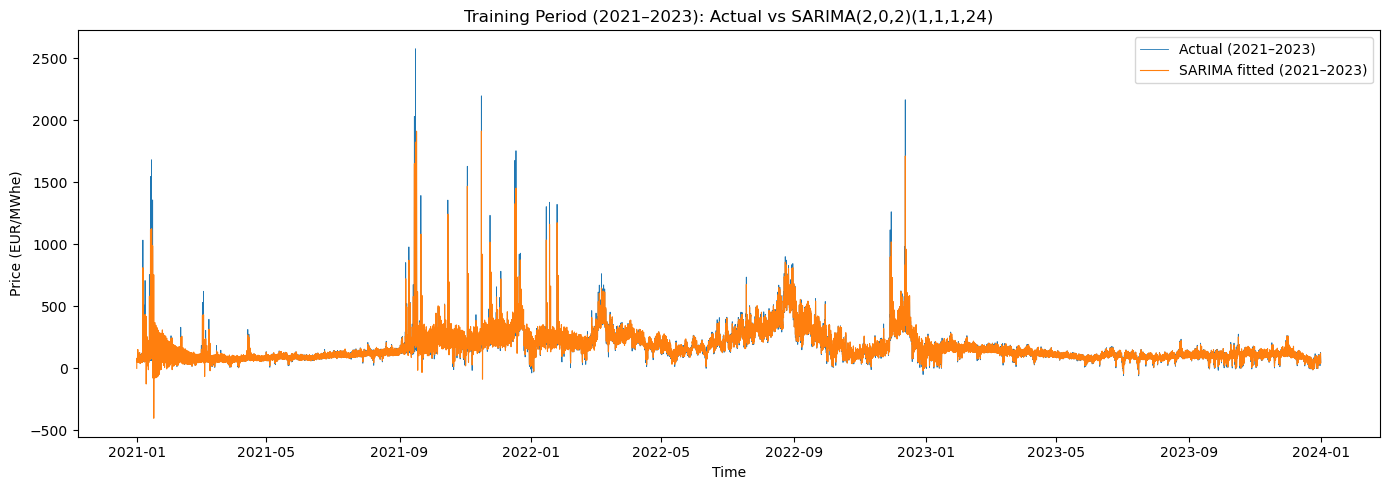

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np

# 重新用訓練資料 fit 最佳 SARIMA
best_model = SARIMAX(
    train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# in-sample fitted values（訓練期間的預測）
fitted_train = best_model.predict(start=train.index[0], end=train.index[-1])

# 2021–2023 圖：Actual vs Fitted
plt.figure(figsize=(14, 5))
plt.plot(train.index, train, label="Actual (2021–2023)", linewidth=0.6)
plt.plot(fitted_train.index, fitted_train, label="SARIMA fitted (2021–2023)", linewidth=0.8)
plt.title("Training Period (2021–2023): Actual vs SARIMA(2,0,2)(1,1,1,24)")
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWhe)")
plt.legend()
plt.tight_layout()
plt.show()

Best SARIMA RMSE on 2024 test: 35.64324958327589


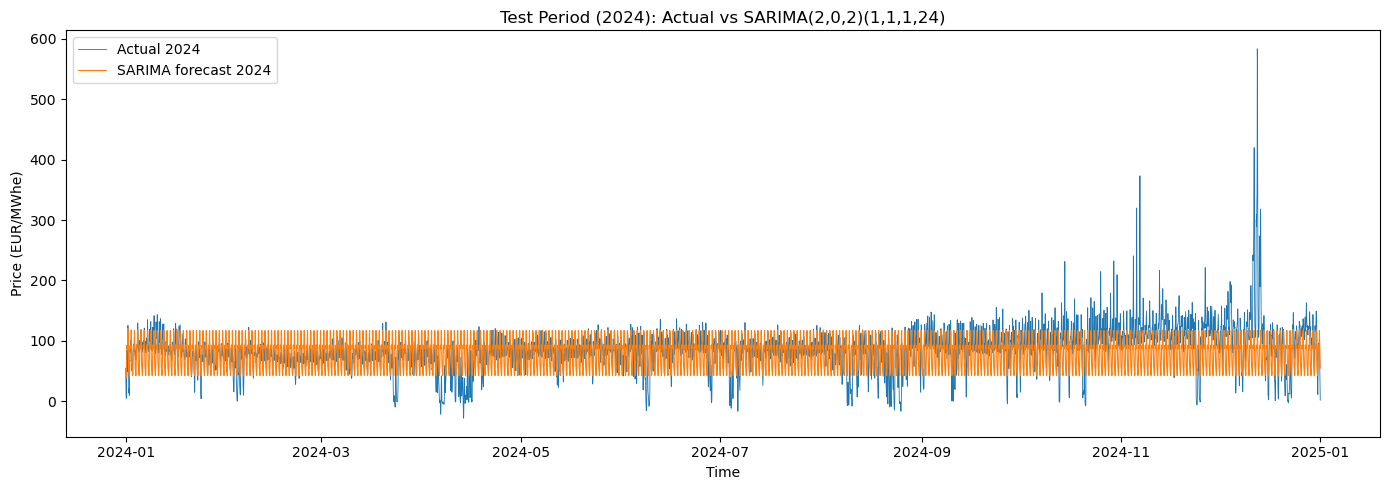

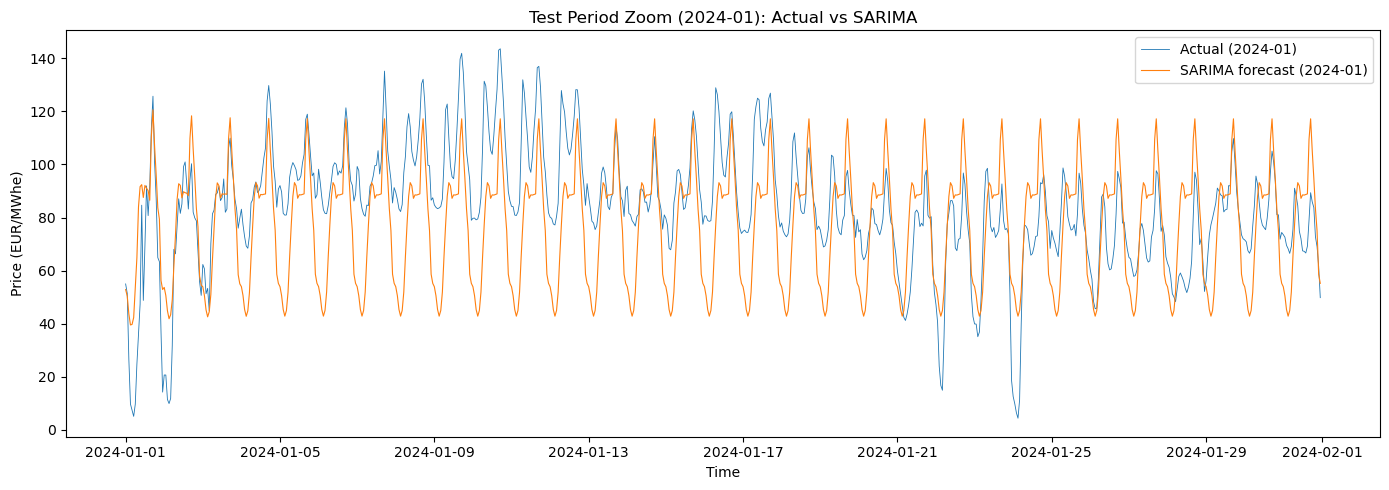

In [9]:
# 用剛才同一個 best_model 對 2024 做預測
forecast_test = best_model.forecast(steps=len(test))

# 保險起見，讓 index 對齊 test
forecast_test.index = test.index

# 計算 RMSE
rmse = np.sqrt(((forecast_test - test) ** 2).mean())
print("Best SARIMA RMSE on 2024 test:", rmse)

# 2024 圖：Actual vs Forecast
plt.figure(figsize=(14, 5))
plt.plot(test.index, test, label="Actual 2024", linewidth=0.6)
plt.plot(test.index, forecast_test, label="SARIMA forecast 2024", linewidth=0.8)
plt.title("Test Period (2024): Actual vs SARIMA(2,0,2)(1,1,1,24)")
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWhe)")
plt.legend()
plt.tight_layout()
plt.show()

# 再選一個月份放大（例如 2024-01）
start_zoom = "2024-01-01"
end_zoom   = "2024-01-31"

test_zoom = test.loc[start_zoom:end_zoom]
fc_zoom   = forecast_test.loc[start_zoom:end_zoom]

plt.figure(figsize=(14, 5))
plt.plot(test_zoom.index, test_zoom, label="Actual (2024-01)", linewidth=0.6)
plt.plot(fc_zoom.index, fc_zoom, label="SARIMA forecast (2024-01)", linewidth=0.8)
plt.title("Test Period Zoom (2024-01): Actual vs SARIMA")
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWhe)")
plt.legend()
plt.tight_layout()
plt.show()

## Forecasting with SARIMA

In [10]:
train_full = price.loc["2021-01-01":"2024-12-31"]

best_order = (2, 0, 2)
best_seasonal = (1, 1, 1, 24)

final_model = SARIMAX(
    train_full,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

start_date = "2025-12-01"
end_date   = "2026-08-31"

future_index = pd.date_range(start=start_date, end=end_date, freq="H")
steps = len(future_index)

forecast_winter_summer = final_model.forecast(steps=steps)
forecast_winter_summer.index = future_index


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/32/nhrql6ss1cq_ktc05s4h9rvm0000gp/T/ipykernel_7933/4023818578.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(start=start_date, end=end_date, freq="H")


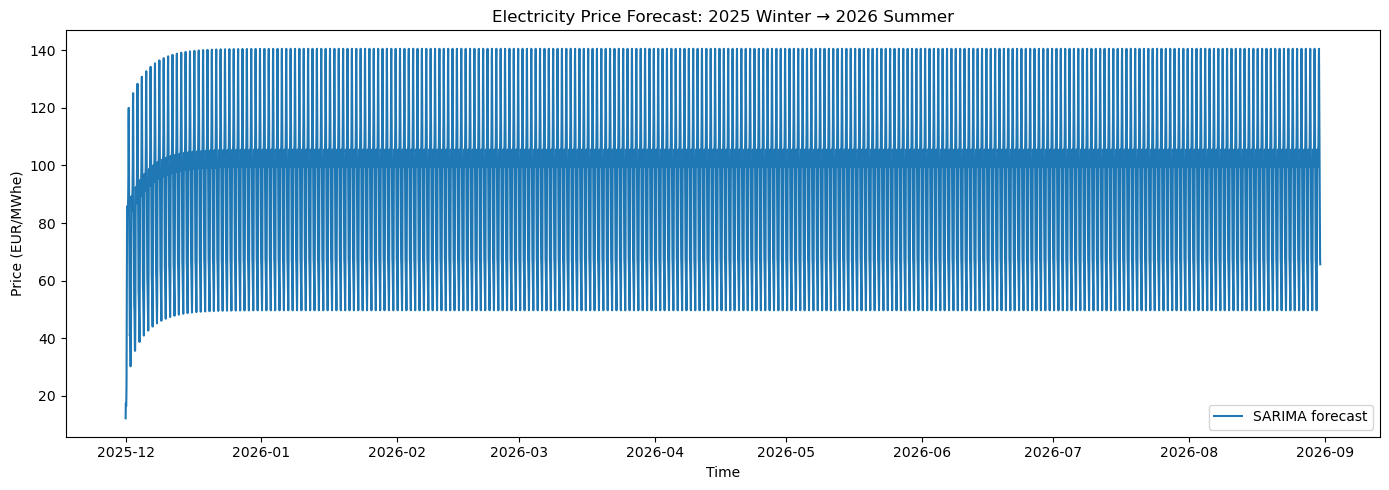

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(forecast_winter_summer.index, forecast_winter_summer, label="SARIMA forecast")
plt.title("Electricity Price Forecast: 2025 Winter → 2026 Summer")
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWhe)")
plt.legend()
plt.tight_layout()
plt.show()

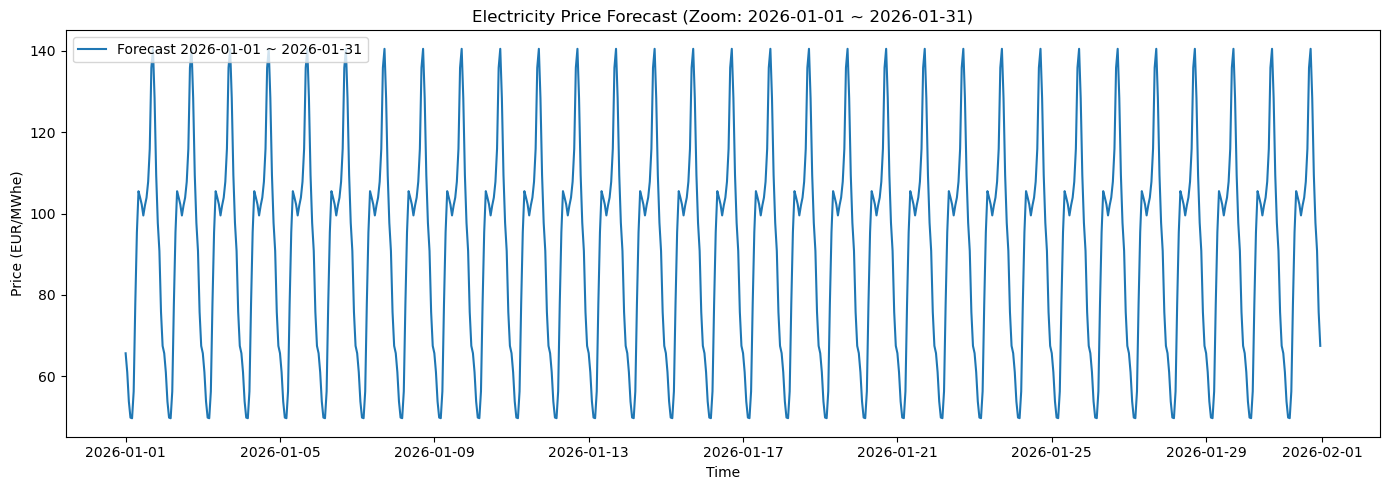

In [14]:
start_zoom = "2026-01-01"
end_zoom   = "2026-01-31"

forecast_zoom = forecast_winter_summer.loc[start_zoom:end_zoom]

plt.figure(figsize=(14, 5))
plt.plot(forecast_zoom.index, forecast_zoom, label=f"Forecast {start_zoom} ~ {end_zoom}")
plt.title(f"Electricity Price Forecast (Zoom: {start_zoom} ~ {end_zoom})")
plt.xlabel("Time")
plt.ylabel("Price (EUR/MWhe)")
plt.legend()
plt.tight_layout()
plt.show()
